Download the dataset from here: 
https://drive.google.com/file/d/1lUmzcMUFJSF60DFMK5yKQClGqg9v8fcP/view?usp=sharing
And extract it into your working directory

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import numpy as np

In [3]:
image_dir = "dataset_X/"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
print(len(images))
images[:2]

9014


['dataset_X/8518.png', 'dataset_X/576.png']

In [4]:
# preprocess
image_size = 64
@tf.function
def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    image = tf.reshape(image, shape = (image_size, image_size, 1,))
    return image

In [5]:
batch_size = 128

training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

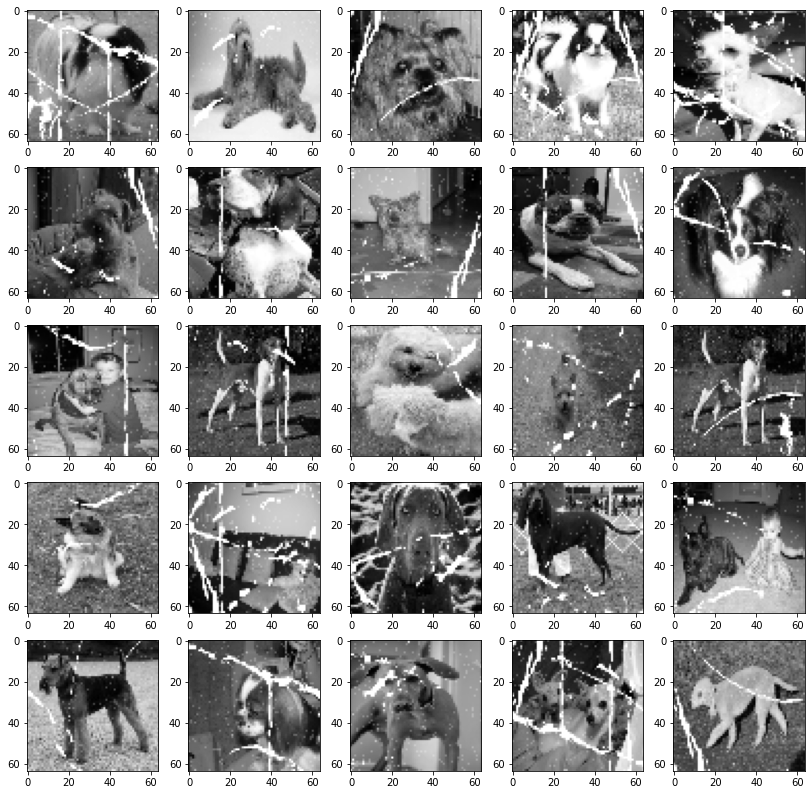

In [6]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx], cmap='gray')
        idx+=1

In [7]:
# build the model
latent_dim = 512

In [8]:
from tensorflow.keras.models import Sequential, Model

import tensorflow.keras
from tensorflow.keras import *

from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.activations import selu
from tensorflow.keras.layers import Multiply, Add
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import backend as K

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import display,Markdown

class SamplingLayer(keras.layers.Layer):
    '''A custom layer that receive (z_mean, z_var) and sample a z vector'''

    def call(self, inputs):
        
        z_mean, z_log_var = inputs
        
        batch_size = tf.shape(z_mean)[0]
        latent_dim = tf.shape(z_mean)[1]
        
        epsilon = keras.backend.random_normal(shape=(batch_size, latent_dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z


In [10]:
print(tf.__version__)
print(keras.__version__)

2.0.0
2.2.4-tf


In [11]:
K.clear_session()

In [12]:
encoder_input    = tf.keras.Input(shape=(64,64,1))
x         = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(encoder_input)
x         = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(512, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(1024, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z         = SamplingLayer()([z_mean, z_log_var])

encoder = tf.keras.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 128)  36992       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 256)    295168      conv2d_1[0][0]                   
____________________________________________________________________________________________

In [13]:
# build the decoder

decoder = Sequential()
decoder.add(Dense(1024, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(1, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_2 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       8

In [14]:
# loss function 
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

In [15]:
# conbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 512), (None, 10951872    input_1[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64, 64, 1)    13281413    encoder[1][2]                    
__________________________________________________________________________________________________
tf_op_layer_add (TensorFlowOpLa [(None, 512)]        0           encoder[1][1]                    
________________________________________________________________________________________________

In [16]:
# make a function to save images while learning
import matplotlib.pyplot as plt
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_, steps = 5)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image, cmap='gray')
            axes[row, column].axis("off")
            idx+=1
    print(prediction)
    output_path = "output/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

In [1]:
# train vae

from tensorflow.keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []


optimizer = Adam(0.0001, 0.5)
epochs = 100
# execution_epoch(epochs,optimizer,model,training_dataset)
for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step,training_batch in enumerate(training_dataset.take(11)):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())
            
            kl = sum(model.losses)
            kl_losses.append(kl.numpy())
            
            train_loss = 0.01 * kl + mse_loss
            
            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

NameError: name 'tf' is not defined

In [1]:
# visualize output

import cv2
output_dir = "output/"
files = os.listdir(output_dir)

for file in files:
    image = cv2.imread(output_dir + file)
    cv2.imshow("Output", image)
    if cv2.waitKey(1) and 0xFF == ord('q'):
        break

NameError: name 'os' is not defined